# Performance Figure
This notebook collects results from different GCN Multi-Omics trainings as well as HotNet2 and MutSigCV. It then shows the performance of all those methods as a scatterplot.
Each method in this plot represents a point and its coordinates represent the performance of it.
The x-axis depicts the performance on the known cancer genes (training + set set for GCN) and the y-axis depicts the performance on the candidate cancer genes from the NCG.

**Different metrics can be chosen to measure the performance. Currently, precision, recall and AUPR can be used.**

Metrics:

* Precision measures the fraction of cancer genes out of all genes that were predicted by the algorithm
* Recall measures the fraction of cancer genes that were found (out of all the cancer genes)
* AUPR measures the area under the precision recall curve, so it incorporates both scores

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
import seaborn as sns
import os, sys
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
import gcnIO
%matplotlib inline

In [44]:
def _get_training_data(training_dir):
    args, data_file = gcnIO.load_hyper_params(training_dir)
    if os.path.isdir(data_file): # FIXME: This is hacky and not guaranteed to work at all!
        network_name = None
        for f in os.listdir(data_file):
            if network_name is None:
                network_name = f.split('_')[0].upper()
            else:
                assert (f.split('_')[0].upper() == network_name)
        fname = '{}_{}.h5'.format(network_name, training_dir.strip('/').split('/')[-1])
        data_file = os.path.join(data_file, fname)
    data = gcnIO.load_hdf_data(data_file)
    return data

def _get_optimal_cutoff(pred, node_names, test_mask, y_test):
    pred_test = pred[pred.Name.isin(node_names[test_mask, 1])]
    y_true = pred_test.label
    y_score = pred_test.Mean_Pred
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    pr = pr[1:]
    rec = rec[1:]
    thresholds = thresholds[1:]
    distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([rec, pr]).T)**2, axis=1))
    idx = np.argmin(distances)
    best_threshold = thresholds[idx]
    return best_threshold

def _get_predictions(train_dir):
    pred_file = os.path.join(train_dir, 'ensemble_predictions.tsv')
    if os.path.isfile(pred_file):
        pred = pd.read_csv(pred_file, sep='\t')
        return pred
    else:
        return None

def _get_metric_score(pred, node_names, knowns, candidates, cutoff, metric='recall'):
    predicted_genes = pred[pred.Mean_Pred >= cutoff]
    y_knowns = pred.Name.isin(knowns)
    y_candidates = pred.Name.isin(candidates)
    if metric.upper() == 'RECALL':
        rec_known = recall_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_knowns)
        rec_cand = recall_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_candidates)
        return rec_known, rec_cand
    elif metric.upper() == 'PRECISION':
        prec_known = precision_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_knowns)
        prec_cand = precision_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_candidates)
        return prec_known, prec_cand
    elif metric.upper() == 'AUPR':
        aupr_known = average_precision_score(y_score=pred.Mean_Pred, y_true=y_knowns)
        aupr_cand = average_precision_score(y_score=pred.Mean_Pred, y_true=y_candidates)
        return aupr_known, aupr_cand
    elif metric.upper() == 'F1':
        f1_known = f1_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_knowns)
        f1_cand = f1_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_candidates)
        return f1_known, f1_cand
    
def get_metrics_for_training(data_dir, metric='recall'):
    precision_scores_knowns = []
    precision_scores_candidates = []
    data_types = []
    for d in os.listdir(data_dir):
        training_dir = os.path.join(data_dir, d)
        if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
            data = _get_training_data(training_dir)
            network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
            pred = _get_predictions(training_dir)
            cutoff = _get_optimal_cutoff(pred, node_names, test_mask, y_test)
            knowns, candidates = get_cancer_genes_for_net(training_dir)
            precision_known, precision_candidates = _get_metric_score(pred, node_names, knowns, candidates, cutoff, metric)
            precision_scores_knowns.append(precision_known)
            precision_scores_candidates.append(precision_candidates)
            data_types.append(d)
    return precision_scores_knowns, precision_scores_candidates, data_types
            

def get_cancer_genes_for_net(model_dir):
    if model_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(model_dir)
    else:
        data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    nodes['label'] = np.logical_or(np.logical_or(y_train, y_test), y_val)

    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])
    known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
    candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

    oncokb_genes = pd.read_csv('/home/sasse/Downloads/cancerGeneList.txt', sep='\t')
    # remove low confidence genes
    oncokb_no_ncg_highconf = oncokb_genes#[oncokb_genes['OncoKB Annotated'] == 'Yes']
    #oncokb_no_ncg_highconf = oncokb_no_ncg_highconf[oncokb_no_ncg_highconf['# of occurrence within resources (Column D-J)'] >= 3]
    # remove all NCG genes
    oncokb_no_ncg = oncokb_no_ncg_highconf[~oncokb_no_ncg_highconf['Hugo Symbol'].isin(known_cancer_genes_innet)]
    oncokb_no_ncg = oncokb_no_ncg[~oncokb_no_ncg['Hugo Symbol'].isin(candidate_cancer_genes_innet)]
    # remove genes that are not in the network
    oncokb_innet = nodes[nodes.Name.isin(oncokb_no_ncg['Hugo Symbol'])].Name
    return oncokb_innet, candidate_cancer_genes_innet


def get_metric_for_mutsigcv(model_dir, metric='recall'):
    # get the basic data
    data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # get the MutSigCV scores
    mutsigcv_scores = pd.read_csv('../data/pancancer/mutsigcv/mutsigcv_genescores.csv',
                                  index_col=0, sep='\t').max(axis=1)
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    mutsigcv_scores_filled = mutsigcv_scores.reindex(nodes.Name).fillna(0)
    mutsigcv_df = pd.DataFrame(mutsigcv_scores_filled, columns=['Mean_Pred'])
    mutsigcv_df['Name'] = mutsigcv_df.index
    mutsigcv_df['label'] = y_test
    # get known and candidate cancer genes
    knowns, candidates = get_cancer_genes_for_net(model_dir)
    # get cutoff
    cutoff = _get_optimal_cutoff(mutsigcv_df, node_names, test_mask, y_test)
    # compute metric
    return _get_metric_score(mutsigcv_df, node_names, knowns, candidates, cutoff, metric)

def get_hotnet2_results():
    hotnet2_results = {}
    with open('../data/pancancer/hotnet2/hotnet2_results/hotnet2_subnetworks.csv', 'r') as f:
        current_network = None
        current_datatype = None
        all_genes_current = []
        counter = 0
        for line in f.readlines():
            if line.split('\t')[0] in ['HINT+HI2012', 'iRefIndex', 'Multinet']:
                if current_network is None or len(all_genes_current) == 0:
                    pass
                else:
                    hotnet2_results['{}_{}'.format(current_network, current_datatype)] = list(set(all_genes_current))
                current_network = line.split('\t')[0]
                current_datatype = line.split('\t')[1]
                all_genes_current = []
            if current_network is None:
                continue
            genes = [i.strip() for i in line.split('\t')[2:] if not i in ['', '\n']]
            all_genes_current += genes
        hotnet2_results['{}_{}'.format(current_network, current_datatype)] = list(set(all_genes_current))
    return hotnet2_results

def compute_hotnet2_metrics(metric='recall'):
    collected = []
    datatypes = []
    networks = []
    hotnet2_results = get_hotnet2_results()
    for key in hotnet2_results:
        res_df = pd.DataFrame(hotnet2_results[key], columns=['Name'])
        res_df['Mean_Pred'] = 1
        if key.split('_')[0] == 'Multinet':
            data_dir = dir_multinet
            net = 'Multinet'
        elif key.split('_')[0] == 'iRefIndex':
            data_dir = dir_iref
            net = 'IREF'
        else:
            continue
        data = _get_training_data(os.path.join(data_dir, 'multiomics'))
        knowns, candidates = get_cancer_genes_for_net(os.path.join(data_dir, 'multiomics'))
        network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
        nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
        res_df_hotnet2 = res_df.set_index('Name').reindex(nodes.Name).fillna(0)
        res_df_hotnet2['Name'] = res_df_hotnet2.index
        collected.append(_get_metric_score(res_df_hotnet2, node_names, knowns, candidates, 0.5, metric=metric))
        datatype = 'Hotnet2 ({} Scores)'.format(key.split('_')[1])
        datatypes.append(datatype)
        networks.append(net)
    result = pd.DataFrame(collected, index=datatypes, columns=['Known Cancer Genes', 'Candidate Cancer Genes'])
    result['Method'] = datatypes
    result['Network'] = networks
    result['ind'] = 'HotNet2'
    result.set_index('ind', inplace=True)
    return result

def compute_deepwalk_metrics(embedding_file, input_file, network_name, metric='recall'):
    data = gcnIO.load_hdf_data(input_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # train SVM on deepWalk embeddings
    deepwalk_embeddings = pd.read_csv(embedding_file,
                                      header=None, skiprows=1, sep=' ')

    deepwalk_embeddings.columns = ['Node_Id'] + deepwalk_embeddings.columns[1:].tolist()
    deepwalk_embeddings.set_index('Node_Id', inplace=True)
    n_df = pd.DataFrame(node_names, columns=['ID', 'Name'])
    embedding_with_names = deepwalk_embeddings.join(n_df)
    X_dw = embedding_with_names.set_index('Name').reindex(n_df.Name).drop('ID', axis=1)
    X_train_dw = X_dw[train_mask.astype(np.bool)]
    X_test_dw = X_dw[test_mask.astype(np.bool)]
    clf_dw = SVC(kernel='rbf', class_weight='balanced', probability=True)
    clf_dw.fit(X_train_dw, y_train[train_mask.astype(np.bool)].reshape(-1))
    pred_deepwalk = clf_dw.predict_proba(X_dw)
    pred_dw_df = pd.DataFrame(pred_deepwalk, columns=['Mean_Pred', 'Pred_neg'], index=X_dw.index).drop('Pred_neg', axis=1)
    pred_dw_df['Name'] = pred_dw_df.index
    pred_dw_df['label'] = y_test
    cutoff_dw = _get_optimal_cutoff(pred_dw_df, node_names, test_mask, y_test)
    knowns, candidates = get_cancer_genes_for_net(input_file)
    perf = _get_metric_score(pred_dw_df, node_names, knowns, candidates, cutoff_dw, metric=metric)
    perf_df = pd.DataFrame(list(perf),
                           index=['Known Cancer Genes', 'Candidate Cancer Genes'],
                           columns=['DeepWalk']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'DeepWalk + SVM'
    return perf_df

def compute_gat_metrics(gat_result_file, gat_input_file, network_name, metric='recall'):
    gat_results = np.load(gat_result_file)
    gat_results = gat_results.reshape(gat_results.shape[1], gat_results.shape[2])
    data = gcnIO.load_hdf_data(gat_input_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    pred = pd.DataFrame(node_names, columns=['ID', 'Name'])
    pred['Mean_Pred'] = gat_results[:, 1] # assuming same order
    pred['label'] = y_test
    cutoff = _get_optimal_cutoff(pred, node_names, test_mask, y_test)
    knowns, candidates = get_cancer_genes_for_net(gat_input_file)
    perf = _get_metric_score(pred, node_names, knowns, candidates, cutoff, metric=metric)
    perf_df = pd.DataFrame(list(perf),
                           index=['Known Cancer Genes', 'Candidate Cancer Genes'],
                           columns=['GAT']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'GAT'
    return perf_df

## Plot metrics for multiple trainings in one figure

In [46]:
metric_of_choice = 'aupr'

# get metrics from different multi-omics trainings
print ("Computing GCN metrics")
dir_multinet = '../data/GCN/training/all_multiomics_multinet/'
dir_cpdb = '../data/GCN/training/all_omics_mymutationsnocna_rownormalized/'
dir_iref = '../data/GCN/training/all_multiomics_IREF/'
dir_mutsigscores = '../data/GCN/training/all_multiomics_IREF_mutsigcvscores/'
dir_withcna = '../data/GCN/training/all_multiomics_IREF_withCNA/'
training_runs = {'Multinet': dir_multinet, 'CPDB': dir_cpdb,
                 'IREF':dir_iref, 'IREF (MutSigCV)': dir_mutsigscores,
                 'IREF (CNA included)': dir_withcna
                }
all_metrics = []
for network_name in training_runs:
    metric_known, metric_candidates, omics = get_metrics_for_training(training_runs[network_name],
                                                                      metric=metric_of_choice)
    x = pd.DataFrame([metric_known, metric_candidates], columns=omics,
                     index=['Known Cancer Genes', 'Candidate Cancer Genes']).T
    x['Network'] = network_name
    all_metrics.append(x)
all_metrics_df = pd.concat(all_metrics)
all_metrics_df['Method'] = all_metrics_df.index

# get mutsigcv metrics
print ("Loading MutSigCV performance")
mutsigcv_perf = []
for network_name, network_dir in {'Multinet': dir_multinet, 'CPDB': dir_cpdb, 'IREF':dir_iref}.items():
    ms_perf_known, ms_perf_cand = get_metric_for_mutsigcv(os.path.join(network_dir, 'multiomics'), metric=metric_of_choice)
    mutsigcv_perf.append([ms_perf_known, ms_perf_cand, network_name])
mutsig_perf_df = pd.DataFrame(mutsigcv_perf, columns=['Known Cancer Genes', 'Candidate Cancer Genes', 'Network'])
mutsig_perf_df['Method'] = 'MutSigCV'
mutsig_perf_df.set_index('Method', inplace=True)
mutsig_perf_df['Method'] = 'MutSigCV'

# compute metrics for HotNet2 results
print ("Computing HotNet2 metrics")
hotnet2_perf = compute_hotnet2_metrics(metric=metric_of_choice)

# compute metrics for deepwalk
print ("Computing DeepWalk metrics")
dw_resdir = '../data/pancancer/deepWalk_results/'
input_basedir = '../data/pancancer/'
dw_paths = {'IREF': ('IREF_embedding_CPDBparams.embedding', 'multiomics_containers/IREF_multiomics.h5'),
             'Multinet': ('MULTINET_embedding_CPDBparams.embedding', 'all_omics_multinet/MULTINET_multiomics.h5'),
             'CPDB': ('CPDB_embedding_CPDBparams.embedding', 'CPDB_multiomics_omimallneg.h5')}
dw_dfs = []
for key in dw_paths:
    res, inp = dw_paths[key]
    dw_dfs.append(compute_deepwalk_metrics(os.path.join(dw_resdir, res),
                                           os.path.join(input_basedir, inp),
                                           network_name=key,
                                           metric=metric_of_choice)
                  )
dw_perf = pd.concat((dw_dfs))

# compute metrics for GAT
print ("Computing GAT metrics")
gat_resdir = '../data/pancancer/gat_results/'
input_basedir = '../data/pancancer/'
gat_paths = {'IREF': ('results_GAT_IREF.npy', 'multiomics_containers/IREF_multiomics.h5'),
             'Multinet': ('results_GAT_MULTINET.npy', 'all_omics_multinet/MULTINET_multiomics.h5'),
             'CPDB': ('results_GAT_attention8_CPDB.npy', 'all_omics_CPDB/CPDB_multiomics.h5')}
gat_dfs = []
for key in gat_paths:
    res, inp = gat_paths[key]
    gat_dfs.append(compute_gat_metrics(os.path.join(gat_resdir, res),
                                       os.path.join(input_basedir, inp),
                                       network_name=key,
                                       metric=metric_of_choice)
                  )
gat_perf = pd.concat((gat_dfs))

all_metrics_df = pd.concat((all_metrics_df, mutsig_perf_df, hotnet2_perf, dw_perf, gat_perf))

Computing GCN metrics
Loading MutSigCV performance
Computing HotNet2 metrics
Computing DeepWalk metrics
Computing GAT metrics


In [52]:
all_metrics_df_relevant = all_metrics_df[all_metrics_df.index.isin(['multiomics', 'methylation_expression',
                                                                     'expression_mutation', 'mutations',
                                                                     'MutSigCV', 'DeepWalk', 'GAT', 'HotNet2'])]

,Candidate Cancer Genes,Known Cancer Genes,Method,Network
mutations,0.130825,0.028992,GCN (Mutation Frequency only),Multinet
multiomics,0.133645,0.033324,GCN (Multi-Omics),Multinet
methylation_expression,0.103195,0.034558,GCN (No Mutation),Multinet
mutations,0.121415,0.030550,GCN (Mutation Frequency only),CPDB
multiomics,0.138980,0.032493,GCN (Multi-Omics),CPDB
methylation_expression,0.116156,0.033522,GCN (No Mutation),CPDB
mutations,0.164240,0.027578,GCN (Mutation Frequency only),IREF
multiomics,0.151188,0.028557,GCN (Multi-Omics),IREF
methylation_expression,0.115206,0.030790,GCN (No Mutation),IREF
mutations,0.134499,0.029828,GCN (Mutation Frequency only),IREF (MutSigCV)


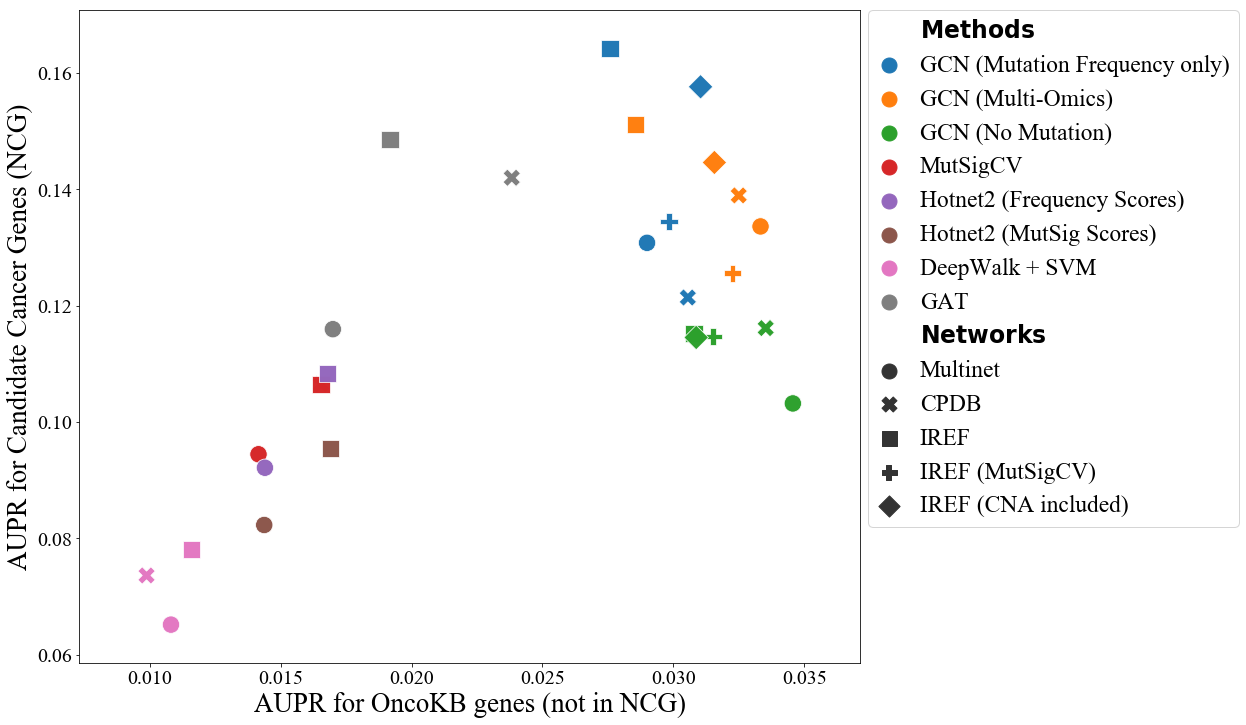

In [57]:
fig = plt.figure(figsize=(14, 12))
replace_dict = {'expression': 'GCN (Expression only)', 'methylation': 'GCN (Methylation only)',
                'mutations': 'GCN (Mutation Frequency only)', 'multiomics': 'GCN (Multi-Omics)',
                'mutation_expression': 'GCN (No Methylation)',
                'methylation_expression': 'GCN (No Mutation)',
                'methylation_mutation': 'GCN (No Expression)',
                'no_cna': 'GCN (No CNA)', 'no_ge': 'GCN (No Expression)',
                'no_meth': 'GCN (No Methylation)', 'no_snvs': 'GCN (No Mutation)'
               }
all_metrics_df.Method = all_metrics_df.Method.replace(replace_dict)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = sns.color_palette(flatui) + sns.xkcd_palette(["dark orange", "windows blue", "amber", "faded green",
                                                       "dusty purple", "light blue"])
sns.scatterplot(data=all_metrics_df_relevant,
                x='Known Cancer Genes',
                y='Candidate Cancer Genes',
                hue='Method', style='Network',
                alpha=.99, s=300)#, palette=colors)
plt.xlabel('{} for OncoKB genes (not in NCG)'.format(metric_of_choice.upper()), fontsize=27)
plt.ylabel('{} for Candidate Cancer Genes (NCG)'.format(metric_of_choice.upper()), fontsize=27)
plt.tick_params(axis='both', labelsize=20)
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 23.5}, handlelength=1,
                    markerscale=2.5)
legend.texts[0].set_text(r"$\bf{Methods}$")
legend.texts[all_metrics_df_relevant.Method.nunique()+1].set_text(r"$\bf{Networks}$")
fig.savefig('../data/pancancer/ensemble_metrics_{}.svg'.format(metric_of_choice), bbox_inches="tight")

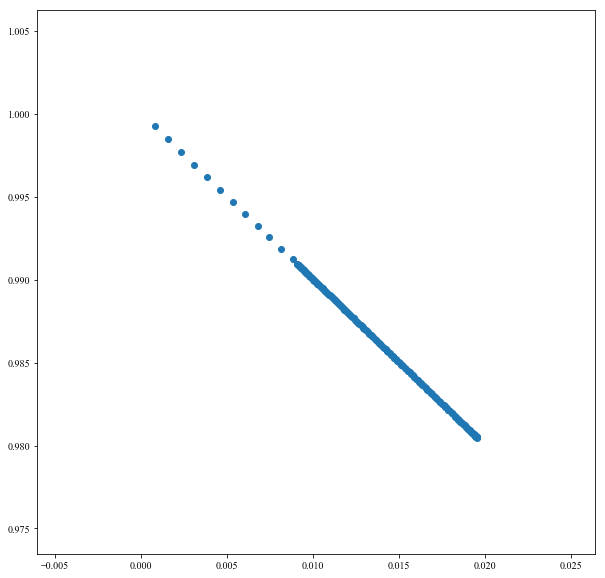

In [5]:

perfect_points_x = []
perfect_points_y = []
onco, cand = get_cancer_genes_for_net('../data/GCN/training/all_multiomics_CPDB/multiomics/')
num_of_tests = len(onco)
for i in range(1, num_of_tests):
    pred = np.concatenate((np.ones(len(cand)), np.ones(i)))
    oncokb = np.concatenate((np.zeros(len(cand)), np.ones(i)))
    cand = np.concatenate((np.ones(len(cand)), np.zeros(i)))
    if metric_of_choice.upper() == 'RECALL':
        score_onco = recall_score(y_pred=pred, y_true=oncokb)
        score_cand = recall_score(y_pred=pred, y_true=cand)
    elif metric_of_choice.upper() == 'PRECISION':
        score_onco = precision_score(y_pred=pred, y_true=oncokb)
        score_cand = precision_score(y_pred=pred, y_true=cand)
    elif metric_of_choice.upper() == 'AUPR':
        score_onco = average_precision_score(y_score=pred, y_true=oncokb)
        score_cand = average_precision_score(y_score=pred, y_true=cand)
    else:
        print ("Metric not recognized")
    perfect_points_x.append(score_onco)
    perfect_points_y.append(score_cand)
    if i % (num_of_tests / 10) == 0:
        print ("Done with {} of {}".format(i, num_of_tests))
fig = plt.figure(figsize=(10, 10))
plt.scatter(perfect_points_x, perfect_points_y)